# Decision Tree를 사용한 feature importance 뽑기

In [1]:
%matplotlib inline
import pandas as pd # 데이터 프레임 처리
import numpy as np # 벡터 계산
import matplotlib.pyplot as plt # 데이터 시각화

# 사이킷런 패키지 활용
from sklearn import tree 
from sklearn.tree.export import export_graphviz
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from scipy.stats import spearmanr

In [2]:
total_20 = pd.read_csv('../data/innovation/Merge_data/df_age20_nowon.csv') # 20대 노원구 데이터
total_30 = pd.read_csv('../data/innovation/Merge_data/df_age30_nowon.csv') # 30대 노원구 데이터
total_40 = pd.read_csv('../data/innovation/Merge_data/df_age40_nowon.csv') # 40대 노원구 데이터
total_50 = pd.read_csv('../data/innovation/Merge_data/df_age50_nowon.csv') # 50대 노원구 데이터

In [3]:
total_20.head()

,age20accum,age20leisure goods,age20leisure busi,age20culture,age20furniture,age20electronic,age20kitchen,age20fuel,age20optic,age20Appliances,...,LCLS_50_P,LCLS_60_P,LCLS_70_P,LCLS_80_P,pm10,pm25,humi,temp,CONTENT,rain
0,432.0,203.0,7993.0,1551.0,21.0,0.0,0.0,498.0,29.0,25.0,...,46787,5417,8331,6619,68.328472,35.256944,56.769284,16.578527,515,0.0
1,105.0,131.0,5367.0,791.0,0.0,0.0,0.0,470.0,63.0,70.0,...,38527,5108,9985,8507,72.005556,29.909028,57.838777,19.628631,888,0.0
2,87.0,126.0,5656.0,526.0,0.0,0.0,18.0,384.0,42.0,43.0,...,36532,6031,7723,4392,72.838194,24.295833,61.681723,19.191452,856,0.1
3,151.0,165.0,5300.0,534.0,0.0,0.0,0.0,308.0,80.0,74.0,...,48128,5592,7261,4501,17.746352,10.958304,60.144545,14.073384,893,18.5
4,187.0,109.0,6001.0,729.0,0.0,0.0,0.0,312.0,89.0,60.0,...,57862,6960,7867,4693,9.926160,3.922644,77.163194,8.620000,864,10.5


In [4]:
# 시계열 데이터로 만들기 위해서 기존의 인덱스를 2018.04.01 ~ 2019.03.31로 변경
dateIdx = pd.date_range('2018-04-01', '2019-03-31')

total_20.index = dateIdx
total_30.index = dateIdx
total_40.index = dateIdx
total_50.index = dateIdx

In [5]:
# 각각의 나이대 별 매출에서 NULL값이 있는지 확인

print("20대 : ", total_20.columns[np.where(total_20.isnull().sum()[:'LCLS_80_P'] != 0)[0]])
print("30대 : ", total_30.columns[np.where(total_30.isnull().sum()[:'LCLS_80_P'] != 0)[0]])
print("40대 : ", total_40.columns[np.where(total_40.isnull().sum()[:'LCLS_80_P'] != 0)[0]])
print("50대 : ", total_50.columns[np.where(total_50.isnull().sum()[:'LCLS_80_P'] != 0)[0]])

20대 :  Index([], dtype='object')
30대 :  Index([], dtype='object')
40대 :  Index([], dtype='object')
50대 :  Index([], dtype='object')


In [6]:
# 각 나이대 별 null columns이 얼마나 있는 지 확인
age20_null = total_20.isnull().sum()[['age20furniture', 'age20electronic', 'age20kitchen', 'age20optic',
                                      'age20Appliances', 'age20textile', 'age20affair', 'age20car sell','age20car repair']]

age30_null = total_30.isnull().sum()[['age30accum', 'age30furniture', 'age30electronic', 'age30kitchen', 'age30optic', 'age30Appliances', 
                                      'age30cloth', 'age30textile', 'age30affair', 'age30car sell', 'age30repair survice']]

age40_null = total_40.isnull().sum()[['age40furniture', 'age40electronic', 'age40kitchen', 'age40optic', 'age40Appliances', 'age40textile', 
                                      'age40affair', 'age40car sell', 'age40repair survice']]

age50_null = total_50.isnull().sum()[['age50accum', 'age50leisure goods', 'age50furniture', 'age50electronic', 'age50kitchen', 'age50optic', 
                                      'age50Appliances', 'age50textile', 'age50affair', 'age50car sell', 'age50car repair','age50repair survice']]

In [7]:
# 이제부터는 각 feature가 CONTENT, pm10, pm25, humi, rain, temp에 영향을 얼마나 받는 지 확인

## 각 연령대 별 feature들을 list로 저장한다

columns_20 = total_20.columns.tolist()
columns_30 = total_30.columns.tolist()
columns_40 = total_40.columns.tolist()
columns_50 = total_50.columns.tolist()

In [8]:
# 20대

target20 = columns_20[:-6]
columns_20 = [c for c in total_20.columns.tolist() if c not in columns_20[:-6]]

train_20 = total_20.sample(frac=0.8, random_state=1234)
test_20 = total_20.loc[~total_20.index.isin(train_20.index)]

models_20 = []
model20_fit = []
feat_importances_20 = []
for i in range(len(target20)) :
    models_20.append(RandomForestRegressor(n_estimators=100, min_samples_leaf=8, random_state=1))

for var, model in zip(target20, models_20) :
    model20_fit.append(model.fit(train_20[columns_20], train_20[var]))

for model in model20_fit :
    feat_importances_20.append(pd.Series(model.feature_importances_, index=total_20.T.index[-6:]))

feat_importances_20_df = pd.DataFrame(feat_importances_20, 
                                      index = target20,
                                      columns = feat_importances_20[0].index)

In [9]:
# 30대

target30 = columns_30[:-6]
columns_30 = [c for c in columns_30 if c not in target30]

train_30 = total_30.sample(frac=0.8, random_state=1234)
test_30 = total_30.loc[~total_30.index.isin(train_30.index)]

models_30 = []
model30_fit = []
feat_importances_30 = []
for i in range(len(target30)) :
    models_30.append(RandomForestRegressor(n_estimators=100, min_samples_leaf=8, random_state=1))

for var, model in zip(target30, models_30) :
    model30_fit.append(model.fit(train_30[columns_30], train_30[var]))

for model in model30_fit :
    feat_importances_30.append(pd.Series(model.feature_importances_, index=total_30.T.index[-6:]))

feat_importances_30_df = pd.DataFrame(feat_importances_30, 
                                      index = target30,
                                      columns = feat_importances_30[0].index)

In [10]:
# 40대

target40 = columns_40[:-6]
columns_40 = [c for c in columns_40 if c not in target40]

train_40 = total_40.sample(frac=0.8, random_state=1234)
test_40 = total_40.loc[~total_40.index.isin(train_40.index)]

models_40 = []
model40_fit = []
feat_importances_40 = []
for i in range(len(target40)) :
    models_40.append(RandomForestRegressor(n_estimators=100, min_samples_leaf=8, random_state=1))

for var, model in zip(target40, models_40) :
    model40_fit.append(model.fit(train_40[columns_40], train_40[var]))

for model in model40_fit :
    feat_importances_40.append(pd.Series(model.feature_importances_, index=total_40.T.index[-6:]))

feat_importances_40_df = pd.DataFrame(feat_importances_40, 
                                      index = target40,
                                      columns = feat_importances_40[0].index)

In [11]:
# 50대

target50 = columns_50[:-6]
columns_50 = [c for c in columns_50 if c not in target50]

train_50 = total_50.sample(frac=0.8, random_state=1234)
test_50 = total_50.loc[~total_50.index.isin(train_50.index)]

models_50 = []
model50_fit = []
feat_importances_50 = []
for i in range(len(target50)) :
    models_50.append(RandomForestRegressor(n_estimators=100, min_samples_leaf=8, random_state=1))

for var, model in zip(target50, models_50) :
    model50_fit.append(model.fit(train_50[columns_50], train_50[var]))

for model in model50_fit :
    feat_importances_50.append(pd.Series(model.feature_importances_, index=total_50.T.index[-6:]))

feat_importances_50_df = pd.DataFrame(feat_importances_50, 
                                      index = target50,
                                      columns = feat_importances_50[0].index)

In [12]:
feat_importances_20_df.drop('age20', inplace = True)
feat_importances_30_df.drop('age30', inplace = True)
feat_importances_40_df.drop('age40', inplace = True)
feat_importances_50_df.drop('age50', inplace = True)

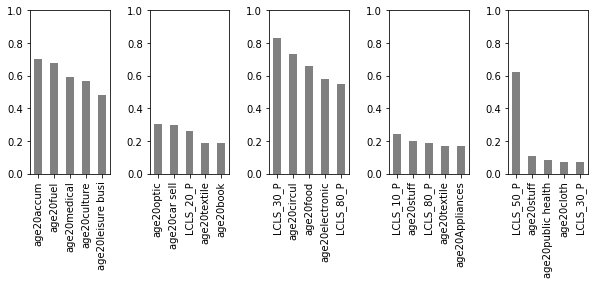

In [14]:
fig4, axes = plt.subplots(1, 5)

feat_importances_20_df.CONTENT.sort_values(ascending = False)[:5].plot(kind = 'bar', ax = axes[0], figsize = (10, 3), ylim = [0, 1], color = 'grey')
feat_importances_20_df.pm10.sort_values(ascending = False)[:5].plot(kind = 'bar', ax = axes[1], figsize = (10, 3), ylim = [0, 1], color = 'grey')
feat_importances_20_df.temp.sort_values(ascending = False)[:5].plot(kind = 'bar', ax = axes[2], figsize = (10, 3), ylim = [0, 1], color = 'grey')
feat_importances_20_df.humi.sort_values(ascending = False)[:5].plot(kind = 'bar', ax = axes[3], figsize = (10, 3), ylim = [0, 1], color = 'grey')
feat_importances_20_df.rain.sort_values(ascending = False)[:5].plot(kind = 'bar', ax = axes[4], figsize = (10, 3), ylim = [0, 1], color = 'grey')

plt.subplots_adjust(wspace = 0.5)
# plt.savefig("/root/Big_Contest/EDA/NOWON/img/feature_importance_20_nowon.png", dpi = 300)

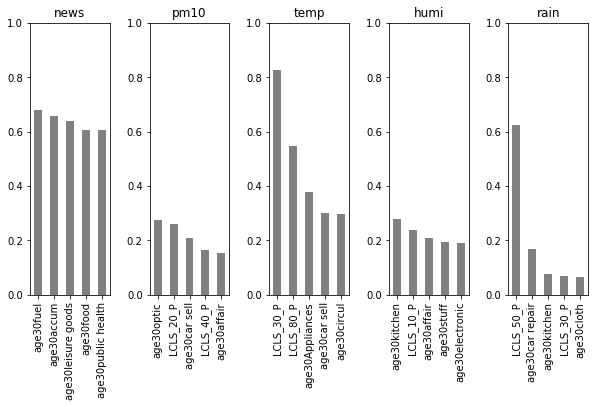

In [15]:
fig5, axes = plt.subplots(1, 5)

feat_importances_30_df.CONTENT.sort_values(ascending = False)[:5].plot(kind = 'bar', ax = axes[0], figsize = (10, 5), title = 'news', ylim = [0, 1], color = 'grey')
feat_importances_30_df.pm10.sort_values(ascending = False)[:5].plot(kind = 'bar', ax = axes[1], figsize = (10, 5), title = 'pm10', ylim = [0, 1], color = 'grey')
feat_importances_30_df.temp.sort_values(ascending = False)[:5].plot(kind = 'bar', ax = axes[2], figsize = (10, 5), title = 'temp', ylim = [0, 1], color = 'grey')
feat_importances_30_df.humi.sort_values(ascending = False)[:5].plot(kind = 'bar', ax = axes[3], figsize = (10, 5), title = 'humi', ylim = [0, 1], color = 'grey')
feat_importances_30_df.rain.sort_values(ascending = False)[:5].plot(kind = 'bar', ax = axes[4], figsize = (10, 5), title = 'rain', ylim = [0, 1], color = 'grey')

plt.subplots_adjust(wspace = 0.5)
# plt.savefig("/root/Big_Contest/EDA/NOWON/img/feature_importance_30_nowon.png", dpi = 300)

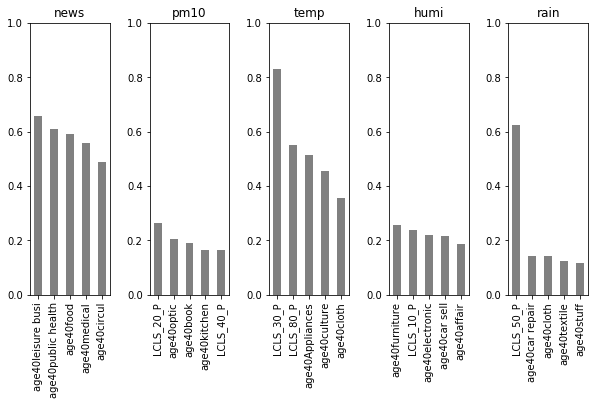

In [16]:
fig6, axes = plt.subplots(1, 5)

feat_importances_40_df.CONTENT.sort_values(ascending = False)[:5].plot(kind = 'bar', ax = axes[0], figsize = (10, 5), title = 'news', ylim = [0, 1], color = 'grey')
feat_importances_40_df.pm10.sort_values(ascending = False)[:5].plot(kind = 'bar', ax = axes[1], figsize = (10, 5), title = 'pm10', ylim = [0, 1], color = 'grey')
feat_importances_40_df.temp.sort_values(ascending = False)[:5].plot(kind = 'bar', ax = axes[2], figsize = (10, 5), title = 'temp', ylim = [0, 1], color = 'grey')
feat_importances_40_df.humi.sort_values(ascending = False)[:5].plot(kind = 'bar', ax = axes[3], figsize = (10, 5), title = 'humi', ylim = [0, 1], color = 'grey')
feat_importances_40_df.rain.sort_values(ascending = False)[:5].plot(kind = 'bar', ax = axes[4], figsize = (10, 5), title = 'rain', ylim = [0, 1], color = 'grey')

plt.subplots_adjust(wspace = 0.5)
# plt.savefig("/root/Big_Contest/EDA/NOWON/img/feature_importance_40_nowon.png", dpi = 300)

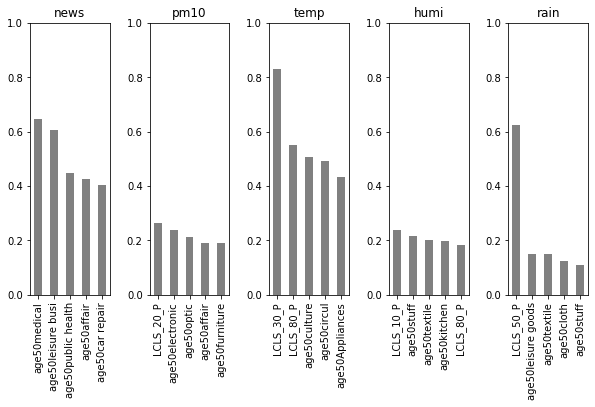

In [17]:
fig7, axes = plt.subplots(1, 5)

feat_importances_50_df.CONTENT.sort_values(ascending = False)[:5].plot(kind = 'bar', ax = axes[0], figsize = (10, 5), title = 'news', ylim = [0, 1], color = 'grey')
feat_importances_50_df.pm10.sort_values(ascending = False)[:5].plot(kind = 'bar', ax = axes[1], figsize = (10, 5), title = 'pm10', ylim = [0, 1], color = 'grey')
feat_importances_50_df.temp.sort_values(ascending = False)[:5].plot(kind = 'bar', ax = axes[2], figsize = (10, 5), title = 'temp', ylim = [0, 1], color = 'grey')
feat_importances_50_df.humi.sort_values(ascending = False)[:5].plot(kind = 'bar', ax = axes[3], figsize = (10, 5), title = 'humi', ylim = [0, 1], color = 'grey')
feat_importances_50_df.rain.sort_values(ascending = False)[:5].plot(kind = 'bar', ax = axes[4], figsize = (10, 5), title = 'rain', ylim = [0, 1], color = 'grey')

plt.subplots_adjust(wspace = 0.5)
# plt.savefig("/root/Big_Contest/EDA/NOWON/img/feature_importance_50_nowon.png", dpi = 300)

In [18]:
feat_importances_20_CONTENT = list(feat_importances_20_df.iloc[np.where(feat_importances_20_df.CONTENT >= 0.4)[0]].index)
feat_importances_20_temp = list(feat_importances_20_df.iloc[np.where(feat_importances_20_df.temp >= 0.4)[0]].index)
feat_importances_20_rain = list(feat_importances_20_df.iloc[np.where(feat_importances_20_df.rain >= 0.4)[0]].index)

feat_importances_30_CONTENT = list(feat_importances_30_df.iloc[np.where(feat_importances_30_df.CONTENT >= 0.4)[0]].index)
feat_importances_30_temp = list(feat_importances_30_df.iloc[np.where(feat_importances_30_df.temp >= 0.4)[0]].index)
feat_importances_30_rain = list(feat_importances_30_df.iloc[np.where(feat_importances_30_df.rain >= 0.4)[0]].index)

feat_importances_40_CONTENT = list(feat_importances_40_df.iloc[np.where(feat_importances_40_df.CONTENT >= 0.4)[0]].index)
feat_importances_40_temp = list(feat_importances_40_df.iloc[np.where(feat_importances_40_df.temp >= 0.4)[0]].index)
feat_importances_40_rain = list(feat_importances_40_df.iloc[np.where(feat_importances_40_df.rain >= 0.4)[0]].index)

feat_importances_50_CONTENT = list(feat_importances_50_df.iloc[np.where(feat_importances_50_df.CONTENT >= 0.4)[0]].index)
feat_importances_50_temp = list(feat_importances_50_df.iloc[np.where(feat_importances_50_df.temp >= 0.4)[0]].index)
feat_importances_50_rain = list(feat_importances_50_df.iloc[np.where(feat_importances_50_df.rain >= 0.4)[0]].index)

In [19]:
print("20대\nCONTENT : ", feat_importances_20_CONTENT)
print("temp : ", feat_importances_20_temp)
print("rain : ", feat_importances_20_rain)

print("\n30대\nCONTENT : ", feat_importances_30_CONTENT)
print("temp : ", feat_importances_30_temp)
print("rain : ", feat_importances_30_rain)

print("\n40대\nCONTENT : ", feat_importances_40_CONTENT)
print("temp : ", feat_importances_40_temp)
print("rain : ", feat_importances_40_rain)

print("\n50대\nCONTENT : ", feat_importances_50_CONTENT)
print("temp : ", feat_importances_50_temp)
print("rain : ", feat_importances_50_rain)

20대
CONTENT :  ['age20accum', 'age20leisure busi', 'age20culture', 'age20fuel', 'age20medical', 'age20public health']
temp :  ['age20leisure goods', 'age20electronic', 'age20circul', 'age20cloth', 'age20book', 'age20car repair', 'age20food', 'age20repair survice', 'LCLS_30_P', 'LCLS_80_P']
rain :  ['LCLS_50_P']

30대
CONTENT :  ['age30accum', 'age30leisure goods', 'age30leisure busi', 'age30culture', 'age30fuel', 'age30circul', 'age30book', 'age30medical', 'age30public health', 'age30food']
temp :  ['LCLS_30_P', 'LCLS_80_P']
rain :  ['LCLS_50_P']

40대
CONTENT :  ['age40accum', 'age40leisure goods', 'age40leisure busi', 'age40fuel', 'age40circul', 'age40stuff', 'age40medical', 'age40public health', 'age40food']
temp :  ['age40culture', 'age40Appliances', 'LCLS_30_P', 'LCLS_80_P']
rain :  ['LCLS_50_P']

50대
CONTENT :  ['age50leisure busi', 'age50affair', 'age50car repair', 'age50medical', 'age50public health']
temp :  ['age50culture', 'age50Appliances', 'age50circul', 'age50cloth', 'LCLS_

# 정리
## 20대 feature importance
1. CONTENT : 숙박(신한) > 연료(신한) > 의료(신한) > 문화취미(신한) > 레저업소(신한) 
2. pm10 : 간식(GS) > 서적(신한) > 홈&리빙(GS) > 수리서비스(신한) > 신변잡화(신한)
3. pm25 : 취미&여가(GS) > 간식(GS) > 홈&리빙(GS) > 사회생활(GS) > 음식(GS)

## 30대 feature importance
1. CONTENT : 연료(신한) > 레저상품(신한) > 요식업소(신한) > 의료(신한) > 레저업소(신한) 
2. pm10 : 간식(GS) > 홈&리빙(GS) > 차량 수리(신한) > 신변잡화(신한) > 서적(신한)
3. pm25 : 취미&여가(GS) > 간식(GS) > 홈&리빙(GS) > 사회생활(GS) > 음식(GS)

## 40대 feature importance
1. CONTENT : 레저업소(신한) > 보건위생(신한) > 요식업소(신한) > 의료(신한) > 유통(신한) 
2. pm10 : 간식(GS) > 서적(신한) > 홈&리빙(GS) > 의복(신한) > 음식(GS)
3. pm25 : 사회생활(GS) > 서적(신한) > 간식(GS) > 홈&리빙(GS) > 레저상품(신한)

## 50대 feature importance
1. CONTENT : 의료(신한) > 레저업소(신한) > 보건위생(신한) > 요식업소(신한) > 사회생활(GS) 
2. pm10 : 간식(GS) > 서적(신한) > 홈&리빙(GS) > 음료식품(신한) > 연료(신한)
3. pm25 : 취미&여가(GS) > 서적(신한) > 간식(GS) > 홈&리빙(GS) > 사회생활(GS)